In [1]:
import random

import numpy as np
import scipy
from matplotlib import pyplot as plt

random.seed(42)

### Unbiased pointwise estimation of fixed kernels

In [2]:
from utils import (
    GroundtruthKernels,
    ModulationFunctions,
    adj_matrix_to_lists,
    frob_norm_error,
    get_random_feature,
    get_U_matrix,
    simulate_walks_from_all,
)

In [3]:
# Choose the hyperparameters.
sigma = 0.25  # Scalar regulariser <1 to ensure that the groundtruth kernels converge
alpha = 20
p_halt = 0.1  # Walker termination probability
nb_random_walks = [2, 4, 8, 16]  # Numbers of random walks /node to sample.
trials = 10  # Number of repeats per number of walks per graph.

ground_truth = GroundtruthKernels(sigma=sigma, alpha=alpha)
modulation_funcs = ModulationFunctions()

# 8 example graphs
adj_matrices = np.load("data/adj_matrices.npy", allow_pickle=True)

In [4]:
# Approximate the graph kernels using the GRFs method.

# Holders for approximation error means and standard deviations.
graphs_all_means = []
graphs_all_stds = []

for graph_id, W in enumerate(adj_matrices, start=1):
    print(f"Approximating kernels for graph {graph_id} of 8...")
    all_errors = []
    all_stds = []

    for kernel_index in range(1, 6):
        U = get_U_matrix(W)  # Normalise the adjacency matrix
        groundtruth, U = ground_truth.get_groundtruth_kernel(
            kernel_index, U
        )  # Compute groundtruth kernel
        adj_lists, weight_lists = adj_matrix_to_lists(U)  # Get the adjacency and weights lists

        # Instantiate lists to hold errors
        errors_log = []
        stds_log = []

        for walks in nb_random_walks:
            errors = []

            for trial in range(trials):
                all_walks_list = simulate_walks_from_all(adj_lists, p_halt, walks)  # Compute the walks
                A = get_random_feature(
                    U, adj_lists, p_halt, all_walks_list, modulation_funcs.functions[kernel_index]
                )  # Approximate the Gram matrix using GRFs
                
                # all_walks_list = simulate_walks_from_all(adj_lists, p_halt, walks)  # Compute the walks
                # B = get_random_feature(
                #     U, adj_lists, p_halt, all_walks_list, modulation_funcs.functions[kernel_index]
                # )  # Approximate the Gram matrix using GRFs
                approx_mat = A @ A.T
                errors.append(
                    frob_norm_error(groundtruth, approx_mat) ** 2
                )  # Record the approximation error
            errors_log.append(np.mean(errors))
            stds_log.append(np.std(errors) / np.sqrt(trials))

        all_errors.append(errors_log)
        all_stds.append(stds_log)

    all_errors = np.asarray(all_errors)
    all_stds = np.asarray(all_stds)

    graphs_all_means.append(all_errors)
    graphs_all_stds.append(all_stds)

print("Done.")

Approximating kernels for graph 1 of 8...
Approximating kernels for graph 2 of 8...
Approximating kernels for graph 3 of 8...
Approximating kernels for graph 4 of 8...
Approximating kernels for graph 5 of 8...
Approximating kernels for graph 6 of 8...
Approximating kernels for graph 7 of 8...
Approximating kernels for graph 8 of 8...
Done.


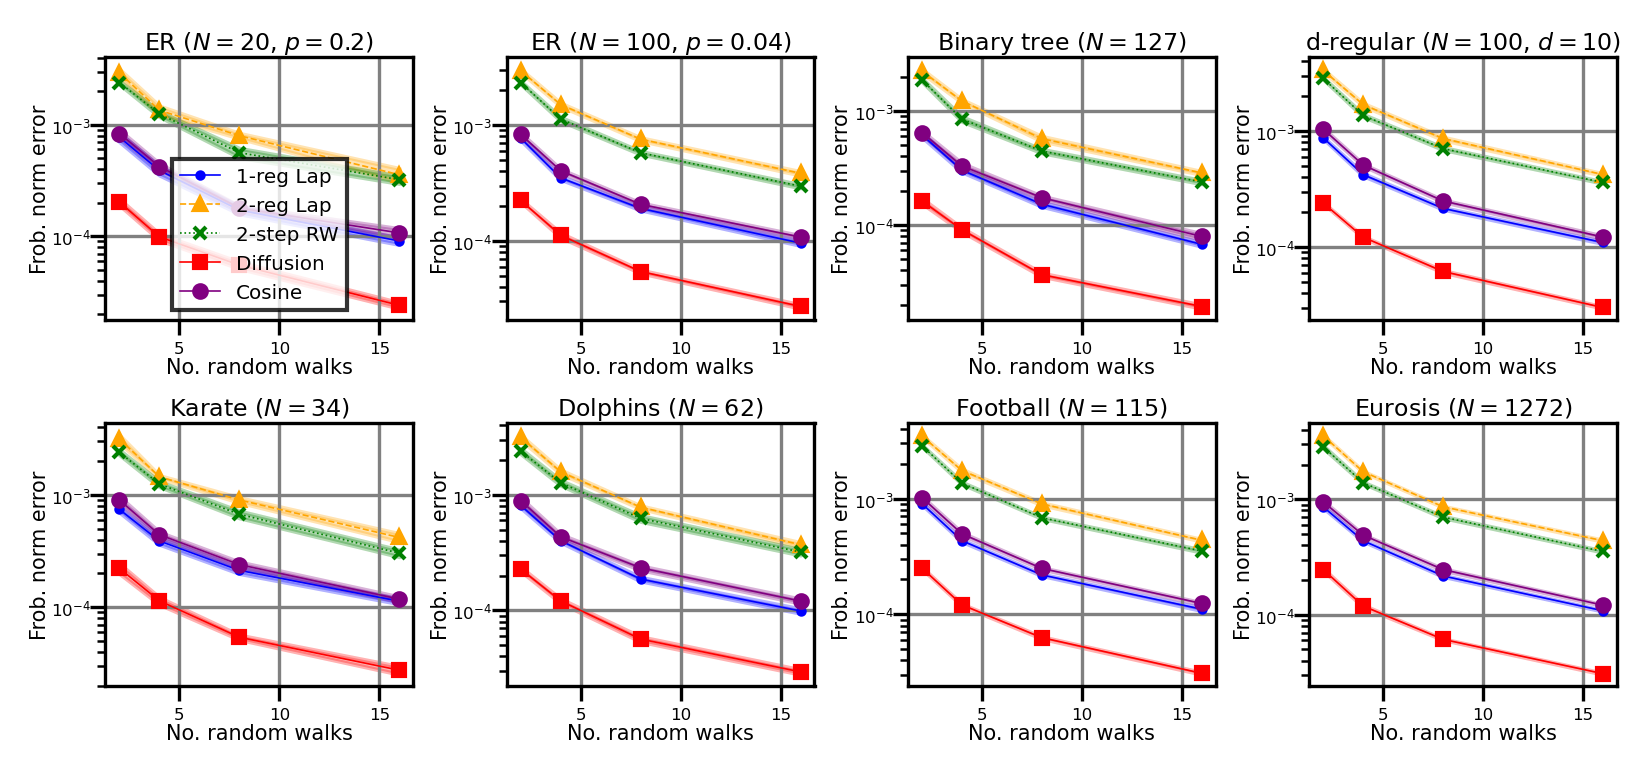

In [5]:
def do_single_plot(ax, means, stds, nb_rnd_walks_list):
    """
    Plotting func for data from GRFs experiment.
    """
    linestyles = ["solid", "dashed", "dotted", "solid", "solid"]
    labels = ["1-reg Lap", "2-reg Lap", "2-step RW", "Diffusion", "Cosine"]
    markers = [".", "^", "x", "s", "o"]
    colors = ["blue", "orange", "green", "red", "purple"]

    nb_rnd_walks_list = np.asarray(nb_rnd_walks_list)
    means = np.asarray(means)
    stds = np.asarray(stds)

    for i in range(5):
        ax.plot(
            nb_rnd_walks_list,
            means[i],
            label=labels[i],
            linestyle=linestyles[i],
            marker=markers[i],
            markersize=3,
            color=colors[i],
        )
        ax.fill_between(
            nb_rnd_walks_list, means[i] - stds[i], means[i] + stds[i], alpha=0.3, color=colors[i]
        )

    ax.set_xlabel("No. random walks", labelpad=0.25, size=5, color="black")
    ax.set_ylabel("Frob. norm error", labelpad=0.25, size=5, color="black")
    ax.grid(color="grey")

rc_temp = {
    "font.size": 4,
    "lines.linewidth": 0.4,
    "xtick.major.pad": 1.5,
    "ytick.major.pad": 0,
    "ytick.minor.pad": 0,
    "ytick.minor.width": 0.6,
    "legend.fancybox": False,
    "legend.framealpha": 0.8,
    "legend.fontsize": "large",
    "legend.edgecolor": "black",
    "legend.facecolor": "white",
    "figure.facecolor": "white",
    "text.color": "black",
}

with plt.rc_context(rc_temp):
    fig, axes = plt.subplots(2, 4, figsize=(5.41, 2.5), dpi=300)
    titles = [
        "ER ($N=20$, $p=0.2$)",
        "ER ($N=100$, $p=0.04$)",
        "Binary tree ($N=127$)",
        "d-regular ($N=100$, $d=10$)",
        "Karate ($N=34$)",
        "Dolphins ($N=62$)",
        "Football ($N=115$)",
        "Eurosis ($N=1272$)",
    ]

    for graph_id, ax in enumerate(axes.flatten()):
        
        do_single_plot(
            ax, 
            graphs_all_means[graph_id], 
            graphs_all_stds[graph_id], 
            nb_random_walks
        )
        
        if graph_id == 0:
            ax.legend()
        ax.set_title(titles[graph_id], pad=2, fontsize=5.7)
        ax.set_yscale("log")


    for ax in axes.flatten():
        ax.set_facecolor("white")
        ax.tick_params(colors="black", which="both")  # Set tick colors to black
        ax.spines["bottom"].set_color("black")  # Set bottom spine to black
        ax.spines["left"].set_color("black")  # Set left spine to black
        ax.spines["top"].set_color("black")  # Set bottom spine to black
        ax.spines["right"].set_color("black")  # Set left spine to black


    fig.tight_layout() 
    plt.show()

### Solving differential equations on graphs

In [6]:
from scipy.integrate import solve_ivp


def solution(W: np.ndarray, y: np.ndarray, t: float) -> np.ndarray:
    def f(t, x):
        return W @ x + y

    x0 = np.zeros(W.shape[0])

    sol = solve_ivp(f, (0, t), x0, method="BDF")
    return sol.y[:, -1]


def estimate_solution(
    W: np.ndarray, y: np.ndarray, p_halt: float, n_walks: int, t: float, n: int
) -> np.ndarray:
    """
    Estimate the solution of the ODE: dx(t)/dt = Wx(t) + y(t), assume x(0) = 0.
    x(t) = E[exp(W(t - k) * y(k))] via Monte Carlo, where
    exp(W(t - k) is estimated via g-GRFs.

    Args:
        W (np.ndarray): W or L, the notation is ambiguous in the paper.
            Here we use W as the normalised adjacency matrix.
        y (np.ndarray): The driving term vector.
        p_halt (float): The walker termination probability.
        n_walks (int): The number of random walks per node.
        t (float): The time parameter.
        n (int): The number of Monte Carlo samples.
    """
    res = np.zeros_like(y, dtype=np.float64)

    for _ in range(n):
        k = 0.5 + t / n  # use discretization instead of random sampling
        adj_lists, _ = adj_matrix_to_lists(W)
        W_p = W * (t - k)
        all_walks_list = simulate_walks_from_all(adj_lists, p_halt, n_walks)
        phi = get_random_feature(W_p, adj_lists, p_halt, all_walks_list, f=modulation_funcs.diffusion)
        res += phi @ (phi.T @ y) * np.exp(k - t)

    return res / n

In [7]:
# Karate, Dolphins, Football
adj_matrices = np.load("data/adj_matrices.npy", allow_pickle=True)[4:7]
t = 1.0
n = 10
trails = 100
nb_random_walks = [2, 4, 8, 16]

In [8]:
graph_errors_mean = []
graph_errors_std = []

for adj in adj_matrices:
    W = get_U_matrix(adj)
    N = W.shape[0]
    E = np.eye(N)

    y = np.zeros(N)
    y[0] = 1.0
    x_true = solution(W - E, y, t)  # use W = - L

    walk_errors_mean = []
    walk_errors_std = []
    for n_walks in nb_random_walks:
        errors = []
        for _ in range(trails):
            x_est = estimate_solution(
                W=W,
                y=y,
                p_halt=0.1,
                n_walks=n_walks,
                t=t,
                n=n,
            )
            error = (np.linalg.norm(x_true - x_est) / np.linalg.norm(x_true))
            errors.append(error)
        walk_errors_mean.append(np.mean(errors))
        walk_errors_std.append(np.std(errors) / np.sqrt(trails))

    graph_errors_mean.append(walk_errors_mean)
    graph_errors_std.append(walk_errors_std)

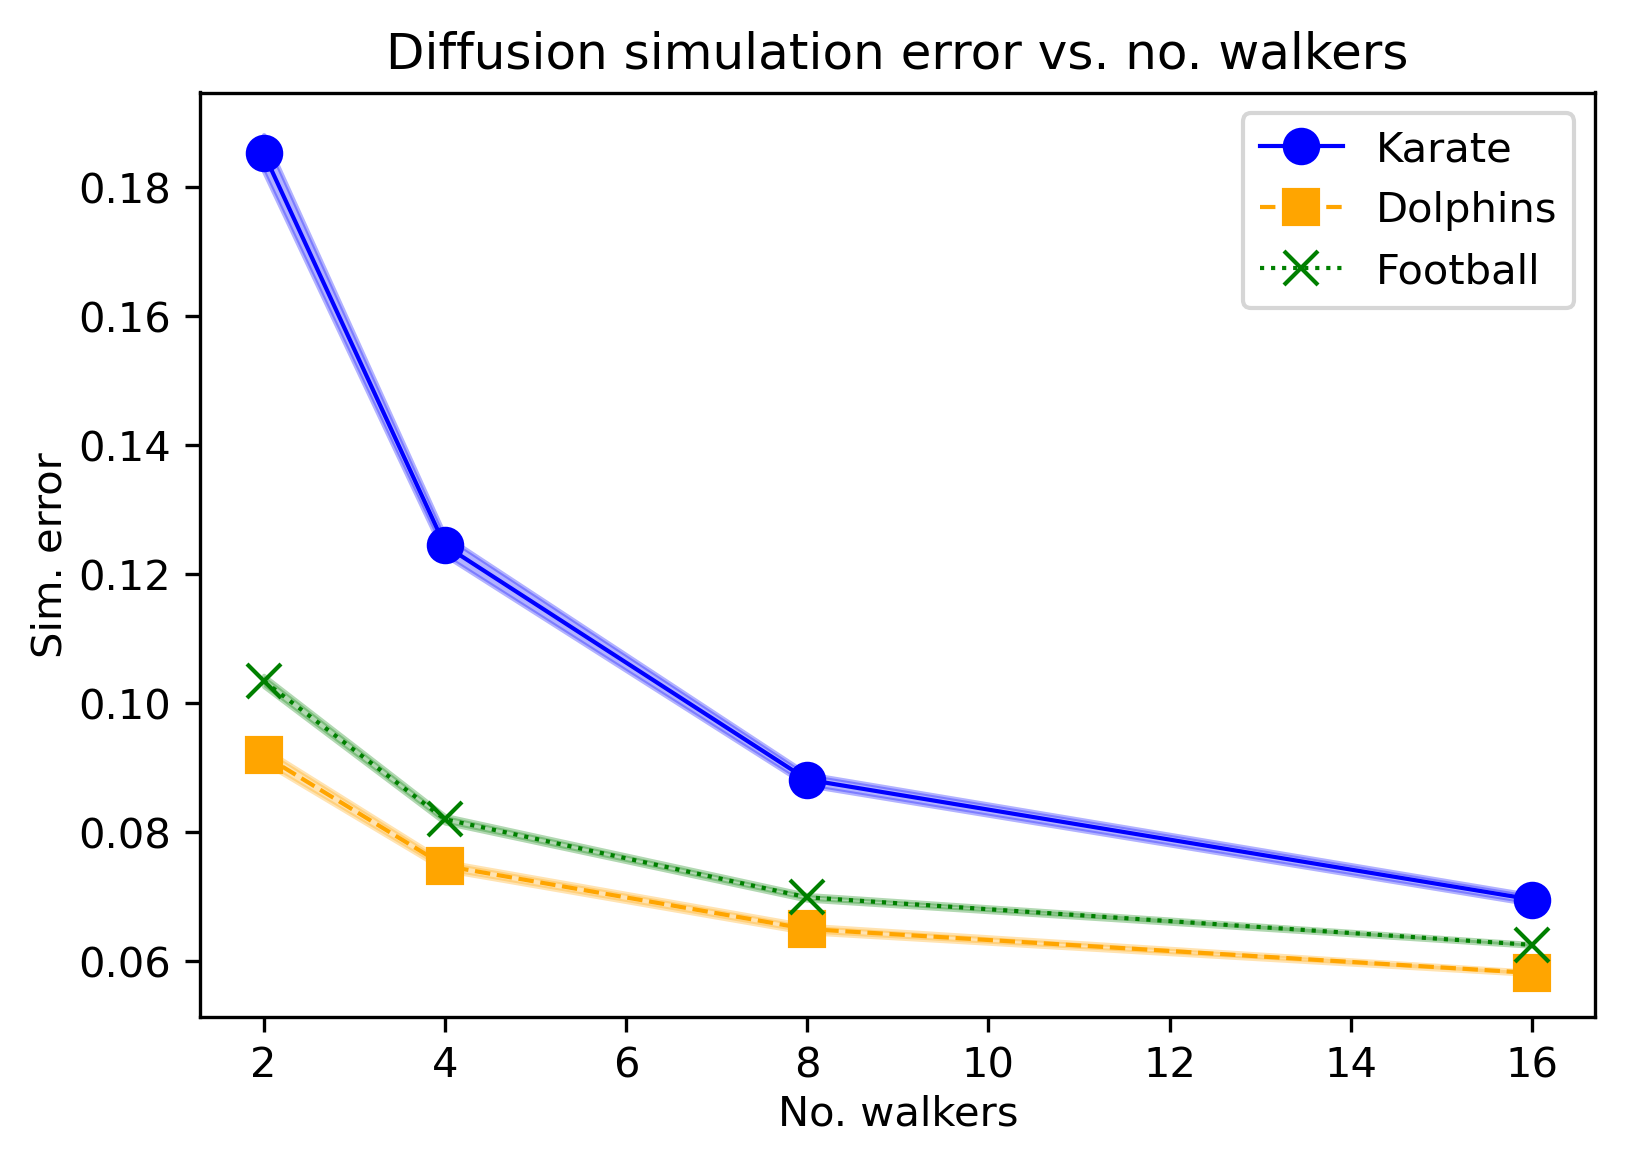

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
labels = ["Karate", "Dolphins", "Football"]
markers = ["o", "s", "x"]
line_styles = ["solid", "dashed", "dotted"]
colors = ["blue", "orange", "green"]
for i in range(3):
    ax.plot(
        nb_random_walks,
        graph_errors_mean[i],
        label=labels[i],
        linestyle=line_styles[i],
        marker=markers[i],
        markersize=8,
        color=colors[i],
        linewidth=1,
    )
    ax.fill_between(
        nb_random_walks,
        np.array(graph_errors_mean[i]) - np.array(graph_errors_std[i]),
        np.array(graph_errors_mean[i]) + np.array(graph_errors_std[i]),
        alpha=0.3,
        color=colors[i],
    )
ax.set_xlabel("No. walkers", labelpad=2, size=10, color="black")
ax.set_ylabel("Sim. error", labelpad=2, size=10, color="black")
ax.legend()
ax.set_title("Diffusion simulation error vs. no. walkers")
plt.show()

### Efficient kernelised graph node clustering

In [10]:
from sklearn.cluster import SpectralClustering

In [11]:
def calculate_cluster_error(true_labels: np.ndarray, pred_labels: np.ndarray) -> float:
    """
    Calculate clustering error given true labels and predicted labels.
    Ec = (no. worong pairs})/ (N choose 2)
    """
    assert len(true_labels) == len(pred_labels)
    n = len(true_labels)

    indicate_mat = true_labels[:, None] == true_labels[None, :]
    pred_indicate_mat = pred_labels[:, None] == pred_labels[None, :]
    wrong_pairs = np.sum(indicate_mat != pred_indicate_mat)

    return float(wrong_pairs / (n * (n - 1)))

In [12]:
sigma_square = 0.2
n_walks = 16
# names = ["karate", "dolphins", "polbooks", "football", "databases", "eurosis", "cora", "citeseer"]
cluster_adj_matrices = np.load("data/clustering_adj_matrices.npz", allow_pickle=True)
# mat_cluster = list(cluster_adj_matrices.values())
# names = list(cluster_adj_matrices.keys())
connected_graphs = set(
    ["karate", "dolphins", "polbooks", "football", "eurosis"]
)

In [13]:
spectral = SpectralClustering(n_clusters=3, affinity="precomputed", random_state=0)

for name, W in cluster_adj_matrices.items():
    if name not in connected_graphs:
        continue
    
    # obtain unweighted adj
    A = np.where(W > 0, 1.0, 0.0)
    A_reg = A * sigma_square
    K = scipy.linalg.expm(A_reg)
    true_labels = spectral.fit_predict(K)

    # approx. K via g-GRFs
    adj_lists, _ = adj_matrix_to_lists(A_reg)
    all_walks_list = simulate_walks_from_all(adj_lists, p_halt, n_walks)
    phi = get_random_feature(A_reg, adj_lists, p_halt, all_walks_list, f=modulation_funcs.diffusion)
    K_approx = phi @ phi.T
    approx_labels = spectral.fit_predict(K_approx)

    error = calculate_cluster_error(true_labels, approx_labels)
    print(f"{name}, N = {A.shape[0]}, Ec: {error:.4f}")

karate, N = 34, Ec: 0.0000
dolphins, N = 62, Ec: 0.1243
polbooks, N = 105, Ec: 0.0000
football, N = 115, Ec: 0.0244
eurosis, N = 1272, Ec: 0.0063


### Learning $f^{(N)}$ for better kernel approximation

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

In [15]:
class NeuralModulationFunction(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 1, bias=True),
            nn.ReLU(),
            nn.Linear(1, 1, bias=True),
            nn.Softplus()
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)
